In [1]:
import pandas as pd
import numpy as np
import json
from gensim.models import Word2Vec
import random
import string
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy import io as scio
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.svm as svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
def document_vector(model, doc):
    vec = [model.wv[word] for word in doc if word in model.wv.index_to_key]
    return np.mean(vec, axis=0) if vec else np.zeros(model.vector_size)

In [23]:
def Standarization(X_train,X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled,X_test_scaled

In [4]:
# 用于存储数据的列表
data_list = []
# 打开训练集文件并逐行读取数据
with open('./exp1_data/train_data.txt', 'r') as file:
    for line in file:
        # 解析JSON数据
        data = json.loads(line.strip())
        data_list.append(data)
# 创建DataFrame
df = pd.DataFrame(data_list)
# 打印前几行以验证结果
df.head()

,label,raw
0,0,I only watched the Wanda Sykes portion of this...
1,0,"This is a cute series, and I did watch two epi..."
2,0,This series revolves around 4 friends who run ...
3,0,"I was pleasantly surprised with this ""out of t..."
4,0,I heard about It's Always Sunny from a Kevin S...


In [5]:
# 打开测试集文件并逐行读取数据
with open('./exp1_data/test.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()  
# 创建一个空的列表，用于存储数据
final_test = []
# 解析文本数据并将其添加到列表中
for i in range(1,len(lines)):
    line = lines[i].strip()
    this_line = []
    if (i>=1) & (i<=10):
        this_text=line[3:]
    elif (i>=11) & (i<=100):
        this_text=line[4:]
    elif (i>=101) & (i<=1000):
        this_text=line[5:]
    else:
        this_text=line[6:]
    this_line.append(this_text)
    final_test.append(this_line)    
# 创建DataFrame
ft = pd.DataFrame(final_test, columns=[ 'text'])
# 显示DataFrame的前几行
ft.head()

,text
0,Considering this was shot in 1972 the video qu...
1,"ok, I know its just random, but it seems like ..."
2,Have used this for 5 months and have seen a di...
3,This app is good but I uninstallled because th...
4,"Yes, I believe they got it right this time, to..."


In [6]:
all_text=""
for i in range(len(df)):
    all_text=all_text+df['raw'][i]+" "    
for i in range(len(ft)):
    all_text=all_text+ft['text'][i]+" "
# 转换为小写
all_text = all_text.lower()
# 去除标点符号
all_text = re.sub(f"[{re.escape(string.punctuation)}]", '', all_text)
# 分词
tokens = all_text.split()
# 去重，构建词表
vocabulary = list(set(tokens))
# 输出词表
print(len(vocabulary))

50194


In [7]:
conbined_textset = []
for i in range(len(df)):
    conbined_textset.append(re.sub(f"[{re.escape(string.punctuation)}]", '', df['raw'][i]))
for i in range(len(ft)):
    conbined_textset.append(re.sub(f"[{re.escape(string.punctuation)}]", '', ft['text'][i]))
combined_corpus = pd.DataFrame(conbined_textset, columns=[ 'text'])
corpus =combined_corpus['text'].apply(lambda x: x.lower().split())
# 训练Word2Vec模型
word2vec = Word2Vec(sentences=corpus, vector_size=100, window=10, min_count=5, sg=1)
word2vec.train(corpus, total_examples=len(corpus), epochs=10)

(8282989, 11845500)

In [8]:
combined_corpus['doc_vector'] = combined_corpus['text'].apply(lambda x: document_vector(word2vec, x.split()))

In [9]:
combined_corpus.head()

,text,doc_vector
0,I only watched the Wanda Sykes portion of this...,"[-0.06968915, -0.048230045, -0.04642534, -0.04..."
1,This is a cute series and I did watch two epis...,"[-0.011499258, -0.0013103822, -0.11865336, -0...."
2,This series revolves around 4 friends who run ...,"[-0.0994866, -0.011678233, -0.04304758, -0.058..."
3,I was pleasantly surprised with this out of th...,"[-0.08626594, -0.014134657, -0.018659806, -0.0..."
4,I heard about Its Always Sunny from a Kevin Sm...,"[-0.10698509, -0.053235725, -0.0753996, -0.082..."


In [10]:
df.loc[:, 'doc_vector'] = combined_corpus['doc_vector'][:8000].values
ft.loc[:, 'doc_vector'] = combined_corpus['doc_vector'][8000:].values

In [11]:
df.head()

,label,raw,doc_vector
0,0,I only watched the Wanda Sykes portion of this...,"[-0.06968915, -0.048230045, -0.04642534, -0.04..."
1,0,"This is a cute series, and I did watch two epi...","[-0.011499258, -0.0013103822, -0.11865336, -0...."
2,0,This series revolves around 4 friends who run ...,"[-0.0994866, -0.011678233, -0.04304758, -0.058..."
3,0,"I was pleasantly surprised with this ""out of t...","[-0.08626594, -0.014134657, -0.018659806, -0.0..."
4,0,I heard about It's Always Sunny from a Kevin S...,"[-0.10698509, -0.053235725, -0.0753996, -0.082..."


In [12]:
ft.head()

,text,doc_vector
0,Considering this was shot in 1972 the video qu...,"[-0.084584676, 0.031909768, -0.026251072, -0.0..."
1,"ok, I know its just random, but it seems like ...","[-0.036672655, -0.048087068, -0.08822724, -0.1..."
2,Have used this for 5 months and have seen a di...,"[-0.14230254, 0.0075209406, 0.03086874, -0.054..."
3,This app is good but I uninstallled because th...,"[-0.08951737, -0.0003368182, -0.041397307, -0...."
4,"Yes, I believe they got it right this time, to...","[-0.09293516, 0.032755002, -0.021602502, -0.10..."


In [13]:
n = len(df)
#设置训练集和测试集的样本比例以及随机数种子
n_train = n*0.8
n_train=int(n_train)
n_test = n-n_train
seed = 19260817
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()
#划分训练集和测试集
Data_train = df.loc[index_selected]
Data_test = df.drop(index = index_selected)

In [14]:
Data_train.head()

,label,raw,doc_vector
0,0,I only watched the Wanda Sykes portion of this...,"[-0.06968915, -0.048230045, -0.04642534, -0.04..."
2,0,This series revolves around 4 friends who run ...,"[-0.0994866, -0.011678233, -0.04304758, -0.058..."
3,0,"I was pleasantly surprised with this ""out of t...","[-0.08626594, -0.014134657, -0.018659806, -0.0..."
5,0,funny thing. My brother's been trying to get m...,"[-0.028365718, -0.036138948, -0.05263852, -0.0..."
6,0,I love it's always sunny and wanted to own the...,"[-0.12668362, -0.0072393613, -0.07949596, -0.0..."


In [15]:
Data_test.head()

,label,raw,doc_vector
1,0,"This is a cute series, and I did watch two epi...","[-0.011499258, -0.0013103822, -0.11865336, -0...."
4,0,I heard about It's Always Sunny from a Kevin S...,"[-0.10698509, -0.053235725, -0.0753996, -0.082..."
11,0,NCIS changed in third season..and gotten stron...,"[0.00017568063, 0.1296811, 0.017859701, 0.0138..."
19,0,My children love this show. I will give a grea...,"[-0.053463183, -0.040864937, -0.06840125, -0.0..."
24,0,What a morose way to end such a fun series. I ...,"[-0.07749346, 0.01645051, -0.100200966, -0.008..."


In [24]:
X_train_prescl = np.array(Data_train['doc_vector'].tolist())
Y_train = Data_train.label
X_test_prescl = np.array(Data_test['doc_vector'].tolist())
Y_test = Data_test.label
X_train,X_test = Standarization(X_train_prescl,X_test_prescl)

In [25]:
print(X_train)

[[0.53985605 0.14717412 0.54258917 ... 0.75814422 0.46561625 0.65139275]
 [0.50531362 0.19357855 0.55020142 ... 0.74455464 0.4470864  0.65655806]
 [0.52063955 0.19046    0.60516268 ... 0.79182477 0.42135595 0.69842009]
 ...
 [0.5175338  0.14605267 0.70642072 ... 0.79892787 0.48484953 0.61310493]
 [0.44760262 0.15060078 0.77442238 ... 0.81333844 0.4336211  0.67882331]
 [0.50359588 0.13766625 0.66869785 ... 0.84276899 0.47840672 0.61955024]]


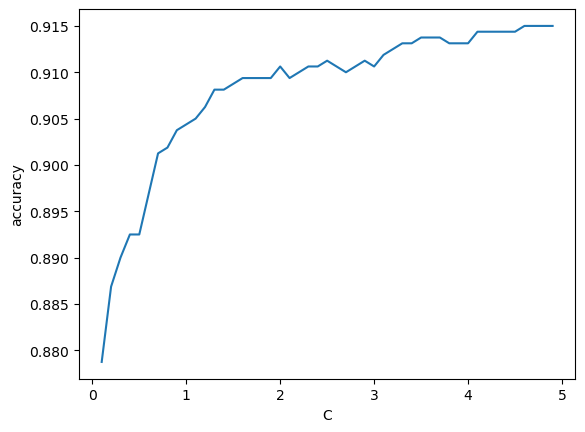

In [18]:
C = []
accu_logreg_C = []
for i in np.arange(0.1, 5, 0.1):
    logreg_para = LogisticRegression(C=i,max_iter=10000)
    logreg_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_logreg = logreg_para.predict(X_test)
    C.append(i)
    accu_logreg_C.append(accuracy_score(Y_test, Y_pred_logreg))
plt.plot(C,accu_logreg_C)
plt.xlabel("C")
plt.ylabel("accuracy")
plt.show()

In [19]:
params_logreg = {'C':np.arange(1, 4, 0.5),'class_weight':['balanced', None],'solver':['liblinear','sag','lbfgs','newton-cg']}
logreg_para = LogisticRegression(max_iter=1000)
clf_logreg = GridSearchCV(logreg_para, param_grid=params_logreg, cv=10)
clf_logreg.fit(X_train, Y_train.values.reshape(-1))
logreg_best=clf_logreg.best_params_

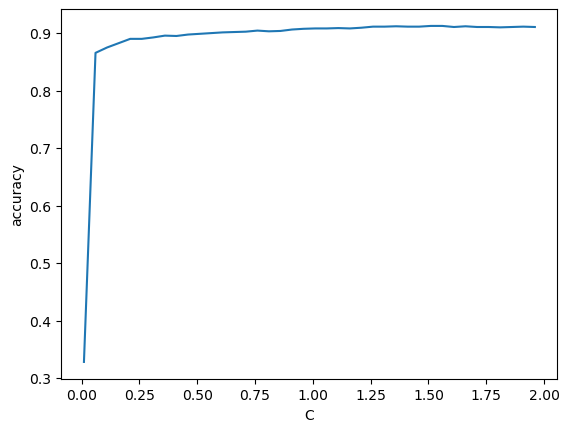

In [22]:
c = []
accu_svm_c = []
for i in np.arange(0.01, 2, 0.05):
    svm_para = svm.SVC(C=i,max_iter=5000)
    svm_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_svm = svm_para.predict(X_test)
    c.append(i)
    accu_svm_c.append(accuracy_score(Y_test, Y_pred_svm))
plt.plot(c,accu_svm_c)
plt.xlabel("C")
plt.ylabel("accuracy")
plt.show()

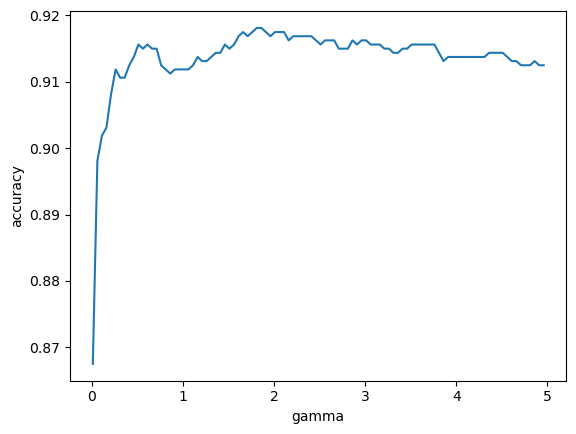

In [25]:
gamma = []
accu_svm_gamma = []
for i in np.arange(0.01, 5, 0.05):
    svm_para = svm.SVC(C=2,gamma=i,max_iter=5000)
    svm_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_svm = svm_para.predict(X_test)
    gamma.append(i)
    accu_svm_gamma.append(accuracy_score(Y_test, Y_pred_svm))
plt.plot(gamma,accu_svm_gamma)
plt.xlabel("gamma")
plt.ylabel("accuracy")
plt.show()

In [20]:
params_svm = {'C':[0.5,1,1.5,2],'gamma':np.arange(0.5,3,0.5)}
svm_para = svm.SVC(max_iter=5000)
clf_svm = GridSearchCV(svm_para, param_grid=params_svm, cv=10)
clf_svm.fit(X_train, Y_train.values.reshape(-1))
svm_best = clf_svm.best_params_

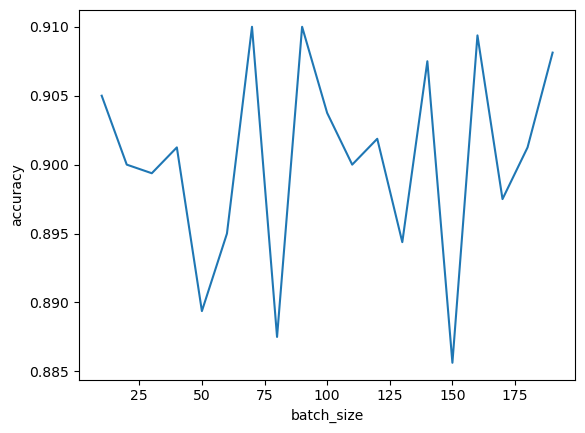

In [27]:
batch_size = []
accu_mlp_batch_size = []
for i in range(10, 200, 10):
    mlp_para = MLPClassifier(max_iter=5000, hidden_layer_sizes=[100, 100])
    mlp_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_mlp = mlp_para.predict(X_test)
    batch_size.append(i)
    accu_mlp_batch_size.append(accuracy_score(Y_test, Y_pred_mlp))
plt.plot(batch_size,accu_mlp_batch_size)
plt.xlabel("batch_size")
plt.ylabel("accuracy")
plt.show()

In [19]:
params_mlp = {"solver": ['adam', 'sgd', 'lbfgs'],"early_stopping":[True,False]}
mlp_para = MLPClassifier(max_iter=5000, hidden_layer_sizes=[100, 100])
clf_mlp = GridSearchCV(mlp_para, param_grid=params_mlp, cv=10)
clf_mlp.fit(X_train, Y_train.values.reshape(-1))
mlp_best=clf_mlp.best_params_

{'early_stopping': False, 'solver': 'sgd'}

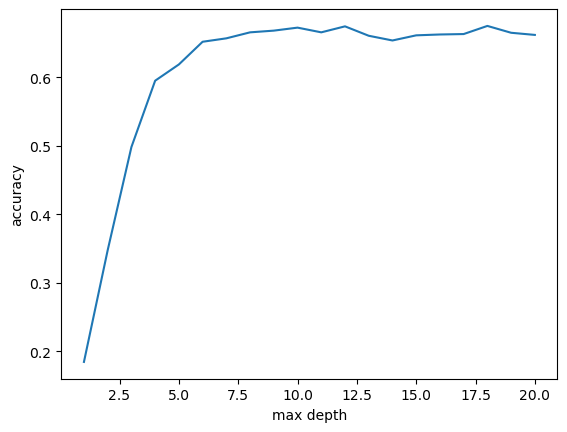

In [25]:
max_depth = []
accu_tree_max_depth = []
for i in range(1,21):
    tree_para = DecisionTreeClassifier(max_depth=i,random_state = 66)
    tree_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_tree = tree_para.predict(X_test)
    max_depth.append(i)
    accu_tree_max_depth.append(accuracy_score(Y_test, Y_pred_tree))
plt.plot(max_depth,accu_tree_max_depth)
plt.xlabel("max depth")
plt.ylabel("accuracy")
plt.show()

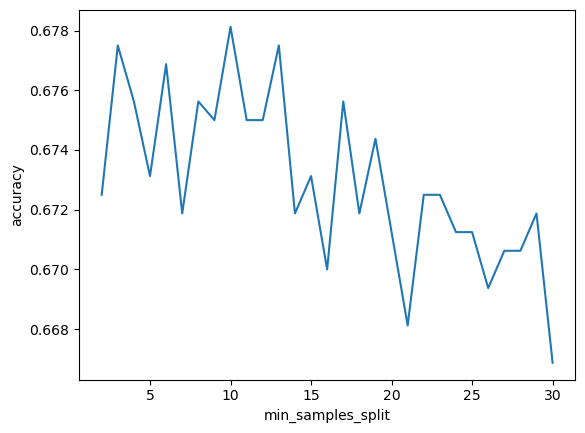

In [27]:
min_samples_split = []
accu_tree_min_samples_split = []
for i in range(2,31):
    tree_para = DecisionTreeClassifier(max_depth=10,min_samples_split=i,random_state = 66)
    tree_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_tree = tree_para.predict(X_test)
    min_samples_split.append(i)
    accu_tree_min_samples_split.append(accuracy_score(Y_test, Y_pred_tree))
plt.plot(min_samples_split,accu_tree_min_samples_split)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

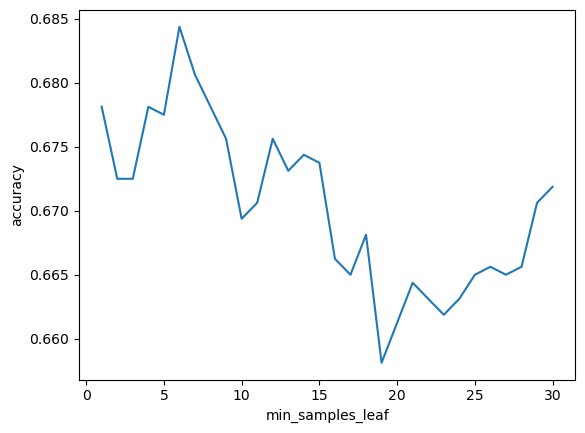

In [30]:
min_samples_leaf = []
accu_tree_min_samples_leaf = []
for i in range(1,31):
    tree_para = DecisionTreeClassifier(max_depth=10,min_samples_split=10,min_samples_leaf=i,random_state = 66)
    tree_para.fit(X_train,Y_train.values.reshape(-1))
    Y_pred_tree = tree_para.predict(X_test)
    min_samples_leaf.append(i)
    accu_tree_min_samples_leaf.append(accuracy_score(Y_test, Y_pred_tree))
plt.plot(min_samples_leaf,accu_tree_min_samples_leaf)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

In [56]:
params_tree = {'max_depth':range(5,10),'min_samples_split':range(2,15),'min_samples_leaf':range(2,6)}
tree_para = DecisionTreeClassifier(random_state = 66)
clf_tree = GridSearchCV(tree_para, param_grid=params_tree, cv=10)
clf_tree.fit(X_train, Y_train.values.reshape(-1))
tree_best=clf_tree.best_params_

{'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 11}

In [17]:
# 将数据集拆分为训练集和验证集
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# 创建分词器，并根据训练集构建词汇表
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['raw'])
# 将文本转换为序列
X_train = tokenizer.texts_to_sequences(train_df['raw'])
X_val = tokenizer.texts_to_sequences(val_df['raw'])
# 填充序列，使它们具有相同的长度
max_length = 128  # 最大长度
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')
# 标签数据
Y_train = train_df['label']
Y_val = val_df['label']
# 模型构建
textRNN = Sequential()
textRNN.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
textRNN.add(LSTM(128))
textRNN.add(Dense(10, activation='softmax'))  # 有10个类别
# 编译模型
textRNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 训练模型
textRNN.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=75, batch_size=64)

Epoch 1/75
100/100 [==============================] - 42s 379ms/step - loss: 2.1960 - accuracy: 0.1534 - val_loss: 2.0410 - val_accuracy: 0.1769
Epoch 2/75
100/100 [==============================] - 37s 370ms/step - loss: 2.0325 - accuracy: 0.1975 - val_loss: 1.8432 - val_accuracy: 0.2350
Epoch 3/75
100/100 [==============================] - 37s 372ms/step - loss: 1.9929 - accuracy: 0.2284 - val_loss: 1.7927 - val_accuracy: 0.2256
Epoch 4/75
100/100 [==============================] - 37s 374ms/step - loss: 1.8125 - accuracy: 0.2917 - val_loss: 2.1760 - val_accuracy: 0.1912
Epoch 5/75
100/100 [==============================] - 40s 398ms/step - loss: 2.0549 - accuracy: 0.2502 - val_loss: 2.0150 - val_accuracy: 0.2456
Epoch 6/75
100/100 [==============================] - 32s 317ms/step - loss: 1.8831 - accuracy: 0.2927 - val_loss: 1.9217 - val_accuracy: 0.2731
Epoch 7/75
100/100 [==============================] - 38s 383ms/step - loss: 1.9310 - accuracy: 0.3084 - val_loss: 2.0179 - val_ac

100/100 [==============================] - 25s 249ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.6794 - val_accuracy: 0.8731
Epoch 58/75
100/100 [==============================] - 23s 234ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.6814 - val_accuracy: 0.8750
Epoch 59/75
100/100 [==============================] - 22s 216ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.6761 - val_accuracy: 0.8769
Epoch 60/75
100/100 [==============================] - 23s 236ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.6785 - val_accuracy: 0.8781
Epoch 61/75
100/100 [==============================] - 24s 239ms/step - loss: 0.0020 - accuracy: 0.9991 - val_loss: 0.6929 - val_accuracy: 0.8794
Epoch 62/75
100/100 [==============================] - 26s 255ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.7009 - val_accuracy: 0.8813
Epoch 63/75
100/100 [==============================] - 25s 247ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.7228 - val_accurac

**以上是调参专区，以下是交叉验证专区**

In [21]:
X=np.array(df['doc_vector'].tolist())
Y=df.label
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
logreg = LogisticRegression(max_iter=1000,**logreg_best)
scores_logreg = cross_val_score(logreg, X, Y, cv=kfold, scoring='accuracy')
print(scores_logreg)

[0.91625  0.908125 0.901875 0.909375 0.899375]


In [37]:
svm = svm.SVC(max_iter=5000,**svm_best)
scores_svm = cross_val_score(svm, X, Y, cv=kfold, scoring='accuracy')
print(scores_svm)

[0.914375 0.898125 0.899375 0.90375  0.900625]


In [43]:
mlp=MLPClassifier(max_iter=5000, hidden_layer_sizes=[100, 100],**mlp_best)
scores_mlp = cross_val_score(mlp, X, Y, cv=kfold, scoring='accuracy')
print(scores_mlp)

[0.901875 0.885    0.895625 0.88125  0.889375]


In [36]:
tree = DecisionTreeClassifier(random_state = 66,**tree_best)
scores_tree = cross_val_score(tree, X, Y, cv=kfold, scoring='accuracy')
print(scores_tree)

[0.6825   0.671875 0.64875  0.66375  0.674375]


**生成预测结果文件**

In [38]:
X_test_hand_in = tokenizer.texts_to_sequences(ft['text'])
X_test_hand_in = pad_sequences(X_test_hand_in, maxlen=max_length, padding='post')
preds = textRNN.predict(X_test_hand_in)
test_ids = ft.index
results_df = pd.DataFrame({'id': test_ids, 'pred': preds.argmax(axis=1)})
with open("results.txt", "w") as file:
    file.write('id, pred\n')
    for i in range(len(results_df)):
        cur_id=results_df['id'][i]
        cur_pred=results_df['pred'][i]
        file.write(f'{cur_id}, {cur_pred}\n')

63/63 [==============================] - 1s 17ms/step
